Quick Start
----
If running on Colab
- Upload requirements.txt
- Upload preprocessing.py
- Upload the data folder

To quickly train a model, you can skip to __Data loading__ section without having to go through the trouble of downloading and partitioning the training data. 

In [1]:
from IPython.display import clear_output
# Installs all the required libraries
!pip install -r requirements.txt
clear_output()

In [30]:
from urllib import request
import math
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, Dataset, DataLoader
import logging
import tqdm
import transformers
from transformers import get_linear_schedule_with_warmup
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import textaugment
import gensim
import string
import numpy as np
from typing import List, Optional, Tuple, Dict
from sklearn.metrics import (
    f1_score,
    recall_score,
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from transformers import (
    AutoTokenizer,
    PreTrainedModel,
    AdamW,
    AutoModel,
    AutoConfig
)

# Sets device
GPU = True
if GPU:
  device = torch.device("cuda"  if torch.cuda.is_available() else "cpu")
else:
  device = torch.device("cpu")
print(f'Using {device}')

BASE_MODEL = "roberta-large"

Using cuda


# Data loading and preprocessing

## Data partitioning

In [3]:
# Code from: https://colab.research.google.com/drive/1M5Qx-FVJYNqFdvpJgggIZaWk5SpGS1Nu?usp=sharing

# Fetches the predefined module to facilitate preprocessing
# Note that if you are running this file locally, you only
# need to fetch and save the file once

module_url = "https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split("/")[-1]

print(f"Fetching {module_url}")

# Saves the content of the module to a local file
with request.urlopen(module_url) as f, open(module_name, "w") as out:
  a = f.read()
  out.write(a.decode("utf-8"))
  print(f"Saved {module_name}")

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py
Saved dont_patronize_me.py


In [43]:
from dont_patronize_me import DontPatronizeMe
from preprocessing import Preprocessor

# Loads data with the provided dataset class
data_dir = "data/"

dataset = DontPatronizeMe(data_dir, data_dir + "task4_test.tsv")
dataset.load_task1()
dataset.load_test()
print(f"Total number of samples loaded: {len(dataset.train_task1_df)}")

# Loads the paragraph IDs of training and test sets
train_ids = pd.read_csv(f"{data_dir}/train_semeval_parids-labels.csv")
test_ids = pd.read_csv(f"{data_dir}/dev_semeval_parids-labels.csv")

train_ids.par_id = train_ids.par_id.astype(str)
test_ids.par_id = test_ids.par_id.astype(str)

preprocessor = Preprocessor()

# Splits the data into training and test sets as per
# the given labels

def partition_data(df: pd.DataFrame,
           ids: pd.DataFrame,
           use_original_labels: bool = False,
           include_categorical_data: bool = True,
           categorical_data_duplicate: int = 16,
           preprocessor: Optional[Preprocessor] = None
           ) -> pd.DataFrame:
  """
  Selects the IDs of the paragraphs in the given dataset
  and creates a new dataframe containing paragraphs with
  the given IDs.

  If `use_original_labels` is True, the original labels of the samples
  will be selected as opposed to the binary labels. For more details 
  about what the original labels mean, please check the paper 
  https://aclanthology.org/2020.coling-main.518.pdf
  """
  rows = []

  for i in tqdm.tqdm(range(len(ids))):
    paragraph_id = ids.par_id[i]

    sample = df[df.par_id == paragraph_id]
    
    # Selects row from original dataset to retrieve `text` and binary label
    text = sample.text.values[0]
    keyword = sample.keyword.values[0]
    country = sample.country.values[0]
    if include_categorical_data:
      keyword = sample.keyword.values[0]
      country = sample.country.values[0]
      text = f"{country} " * categorical_data_duplicate + text
      text = f"{keyword} " * categorical_data_duplicate + text
      text = text + f"{keyword} " * categorical_data_duplicate
      text = text + f"{country} " * categorical_data_duplicate

    if not use_original_labels:
      label = sample.label.values[0]
    else:
      label = sample.orig_label.values[0]
    # Filters out invalid data
    if type(text) != str or text == "":
      continue
    rows.append({
        "par_id": paragraph_id,
        "text": text,
        "label": label,
        "keyword": keyword,
        "country": country
    })

  res = pd.DataFrame(rows)
  if preprocessor:
    preprocessor.preprocess(res)
  return res

print("Partitioning dataset ...")
orig_train_df = partition_data(dataset.train_task1_df, train_ids)

# Uses a certain percentage of the training data as
# the validation set
val_split = 0.1
train_df, val_df = train_test_split(orig_train_df, test_size=val_split, stratify=orig_train_df[["label"]])
test_df = partition_data(dataset.train_task1_df, test_ids, preprocessor=preprocessor)

print(f"\nNumber of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")

Total number of samples loaded: 10469
Partitioning dataset ...

Number of training samples: 7537
Number of validation samples: 838
Number of test samples: 2094


100%|██████████| 3832/3832 [00:13<00:00, 286.73it/s]


## Data Analysis

This section performs analysis on the given PCL dataset

In [46]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

# Helper functions for training data analysis
all_data_df = dataset.train_task1_df
def get_text_token_count(df: pd.DataFrame, 
              label: Optional[int] = None) -> List[int]:
  """
  Splits each text sample in the given dataframe
  into word tokens, and returns a list
  that contains the number of tokens in each sample.
  If `label` is not None, only counts the tokens
  in samples with the given label.
  """
  token_counts = []
  for i in range(len(df)):
    sample = df.iloc[i]
    if label is None or sample.label == label:
      text = sample.text
      tokens = word_tokenize(text)
      token_counts.append(len(tokens))
  
  return token_counts

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
0    9476
1     993
dtype: int64


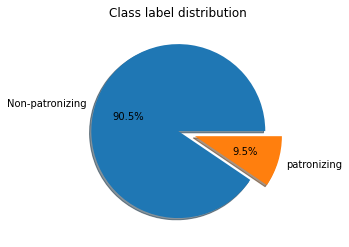

In [47]:
# Plots the class label distribution
label_freq = all_data_df.groupby("label").size()
print(label_freq)
plot = label_freq.plot.pie(y="par_id", title="Class label distribution", legend=False,
                   autopct='%1.1f%%', explode=(0, 0.2), ylabel="",
                   labels=["Non-patronizing", "patronizing"],
                   shadow=True, startangle=0)

In [48]:
# Counts the distribution of categorical data
keyword_freq = all_data_df.groupby(["keyword", "label"]).size()
print(keyword_freq)
# plot = keyword_freq.plot.pie(y="par_id", title="Class label distribution", legend=False,
#                    autopct='%1.1f%%', ylabel="",
#                    shadow=True, startangle=0)

country_freq = all_data_df.groupby(["country", "label"]).size()
print(country_freq)
# plot = country_freq.plot.pie(y="par_id", title="Class label distribution", legend=False,
#                    autopct='%1.1f%%', ylabel="",
#                    shadow=True, startangle=0)

keyword        label
disabled       0         947
               1          81
homeless       0         899
               1         178
hopeless       0         881
               1         124
immigrant      0        1031
               1          30
in-need        0         906
               1         176
migrant        0        1053
               1          36
poor-families  0         759
               1         150
refugee        0         982
               1          86
vulnerable     0        1000
               1          80
women          0        1018
               1          52
dtype: int64
country  label
au       0        504
         1         37
bd       0        468
         1         44
ca       0        484
         1         46
gb       0        483
         1         57
gh       0        448
         1         75
hk       0        461
         1         29
ie       0        485
         1         52
in       0        491
         1         39
jm       0        4

(array([6.900e+02, 3.077e+03, 3.406e+03, 1.625e+03, 8.490e+02, 4.150e+02,
       2.130e+02, 9.800e+01, 5.900e+01, 2.200e+01, 4.000e+00, 2.000e+00,
       2.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00]), array([  0.  ,  18.36,  36.72,  55.08,  73.44,  91.8 , 110.16, 128.52,
       146.88, 165.24, 183.6 , 201.96, 220.32, 238.68, 257.04, 275.4 ,
       293.76, 312.12, 330.48, 348.84, 367.2 , 385.56, 403.92, 422.28,
       440.64, 459.  , 477.36, 495.72, 514.08, 532.44, 550.8 , 569.16,
       587.52, 605.88, 624.24, 642.6 , 660.96, 679.32, 697.68, 716.04,
       734.4 , 752.76, 771.12

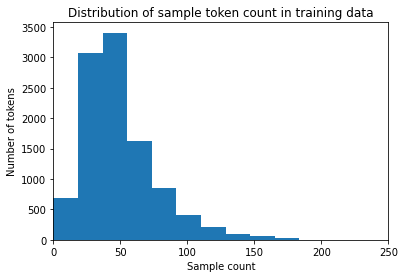

In [49]:
# Plots the distribution of token length in the training data
train_data_token_lens = np.array(get_text_token_count(all_data_df))
distr = plt.hist(train_data_token_lens, bins=50)
print(distr)
print(f"Mean: {np.mean(train_data_token_lens)} | Median: {np.median(train_data_token_lens)}")
plt.title("Distribution of sample token count in training data")
plt.xlim(0, 250)
plt.ylabel('Number of tokens')
plt.xlabel('Sample count');
plt.show()

(array([6.360e+02, 2.846e+03, 3.099e+03, 1.433e+03, 7.410e+02, 3.700e+02,
       1.890e+02, 7.700e+01, 5.300e+01, 2.000e+01, 4.000e+00, 1.000e+00,
       2.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
       0.000e+00, 1.000e+00]), array([  0.  ,  18.36,  36.72,  55.08,  73.44,  91.8 , 110.16, 128.52,
       146.88, 165.24, 183.6 , 201.96, 220.32, 238.68, 257.04, 275.4 ,
       293.76, 312.12, 330.48, 348.84, 367.2 , 385.56, 403.92, 422.28,
       440.64, 459.  , 477.36, 495.72, 514.08, 532.44, 550.8 , 569.16,
       587.52, 605.88, 624.24, 642.6 , 660.96, 679.32, 697.68, 716.04,
       734.4 , 752.76, 771.12

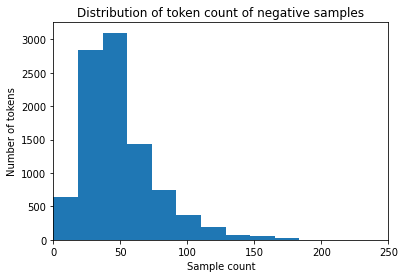

In [50]:
# Plots the distribution of token length of negative samples
neg_token_lens = np.array(get_text_token_count(all_data_df, 0))
distr = plt.hist(neg_token_lens, bins=50)
print(distr)
print(f"Mean: {np.mean(neg_token_lens)} | Median: {np.median(neg_token_lens)}")
plt.title("Distribution of token count of negative samples")
plt.xlim(0, 250)
plt.ylabel('Number of tokens')
plt.xlabel('Sample count')
plt.show()

(array([ 46.,  92., 147., 189., 142., 121.,  74.,  65.,  32.,  28.,  14.,
        13.,  13.,   8.,   3.,   1.,   2.,   0.,   0.,   1.,   0.,   0.,
         0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   1.]), array([  6.  ,  16.28,  26.56,  36.84,  47.12,  57.4 ,  67.68,  77.96,
        88.24,  98.52, 108.8 , 119.08, 129.36, 139.64, 149.92, 160.2 ,
       170.48, 180.76, 191.04, 201.32, 211.6 , 221.88, 232.16, 242.44,
       252.72, 263.  , 273.28, 283.56, 293.84, 304.12, 314.4 , 324.68,
       334.96, 345.24, 355.52, 365.8 , 376.08, 386.36, 396.64, 406.92,
       417.2 , 427.48, 437.76, 448.04, 458.32, 468.6 , 478.88, 489.16,
       499.44, 509.72, 520.  ]), <a list of 50 Patch objects>)
Mean: 55.18831822759315 | Median: 49.0


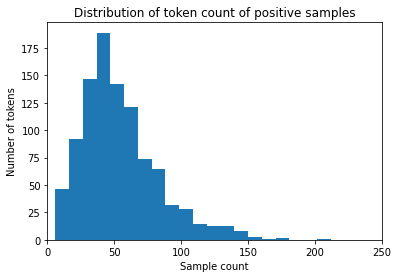

In [51]:
# Plots the distribution of token length of positive samples
pos_token_lens = np.array(get_text_token_count(all_data_df, 1))
distr = plt.hist(pos_token_lens, bins=50)
print(distr)
print(f"Mean: {np.mean(pos_token_lens)} | Median: {np.median(pos_token_lens)}")
plt.title("Distribution of token count of positive samples")
plt.xlim(0, 250)
plt.ylabel('Number of tokens')
plt.xlabel('Sample count')
plt.show()

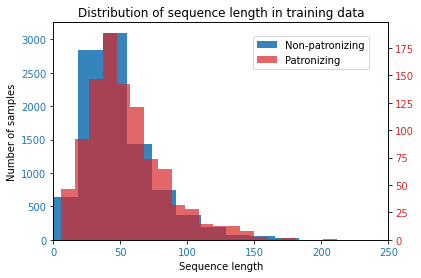

In [52]:
# Plots the distributions of token counts of
# both the negative and positive samples
fig, ax1 = plt.subplots()
neg_distr = ax1.hist(neg_token_lens, bins=50, label="Non-patronizing", alpha=0.9)
ax1.set_ylabel("Number of samples")
ax1.set_xlabel("Sequence length")
ax1.tick_params(labelcolor="tab:blue")

ax2 = ax1.twinx()
pos_distr = ax2.hist(pos_token_lens, bins=50, color="tab:red", label="Patronizing", alpha=0.7)
ax2.tick_params(labelcolor="tab:red")
plt.title("Distribution of sequence length in training data")

fig.legend(loc=(0.6, 0.75))

plt.xlim(0, 250)
plt.show()

## Data augmentation
Tried the [textaugment library](https://github.com/dsfsi/textaugment). However, the sentences augmented with word2vec or wordnet do not make sense at all. Would suggest not to proceed with this library.

__Feel free to add more augmentation__
- Uses contextual word embedding augmentation from the [nlpaug](https://github.com/makcedward/nlpaug) library: performs word insertion and substitution on the original sentences
- Simple synonym replacement
- Random swap
- Random swap + synonym replacement
- Random deletion
- Over samples the positive samples.

In [ ]:
# Performs data augmentation on the training data using nlpaug library
import nlpaug.augmenter.word as naw
from collections import defaultdict
import random
random.seed(69)

# The probability of performing data augmentation on a negative sample
neg_aug_prob = 0
# The probability of performing data augmentation on a positive sample
pos_aug_prob = 1

# Types of augmetnation to perform
aug_types = ["insert", "substitute"]
new_samples = []
new_samples_count = defaultdict(int)

for aug_type in aug_types:
  augmenter = naw.ContextualWordEmbsAug(model_path="roberta-large", 
                       action=aug_type,
                       aug_max=5,
                       device=str(device))
  print(f"Performing {aug_type} augmentation")
  for i in tqdm.tqdm(range(len(train_df))):
    sample = train_df.iloc[i]
    label = sample.label
    prob = pos_aug_prob if label == 1 else neg_aug_prob
    if random.random() <= prob:
      original_text = sample.text
      augmented_text = augmenter.augment(original_text)
      new_samples.append({
          "text": augmented_text,
          "label": label
      })
      new_samples_count[label] += 1

# Concatenates the original training samples with the new samples
augmented_df = pd.concat([train_df, pd.DataFrame(new_samples)])
contextual_word_embeds_df = pd.DataFrame(new_samples)
print(f"\nNew negative samples: {new_samples_count[0]}")
print(f"New positive samples: {new_samples_count[1]}")
print(f"Current number of postive samples: {augmented_df[augmented_df.label == 1].shape[0]}")
print(f"Current number of training samples: {len(augmented_df)}")

In [ ]:
# Performs synonym replacement
from textaugment import EDA
import nltk
import random
random.seed(69)
nltk.download(["stopwords", "wordnet"])

augment = EDA()
replacement_prob = 1

new_samples = []
replaced_word_count = 5
for i in tqdm.tqdm(range(len(train_df))):
  sample = train_df.iloc[i]
  if sample.label == 1 and random.random() <= replacement_prob:
    new_samples.append({
        "text": augment.synonym_replacement(sample.text, replaced_word_count),
        "label": sample.label
    })

augmented_with_synonym_replacement_df = pd.DataFrame(new_samples)
print(f"\nNew positive samples: {len(augmented_with_synonym_replacement_df)}")
save_dataframe(augmented_with_synonym_replacement_df, "data/synonym.csv")

In [ ]:
# Performs random swap augmentation
from textaugment import EDA
import random
random.seed(69)
def augment_with_random_swap(df: pd.DataFrame, 
                augment_prob: float = 1,
                n: int = 10) -> pd.DataFrame:
  """
  Performs random swap augmentation on the given dataset
  """
  augment = EDA()

  new_samples = []
  for i in tqdm.tqdm(range(len(df))):
    sample = df.iloc[i]
    if sample.label == 1 and random.random() <= augment_prob:
      new_samples.append({
          "text": augment.random_swap(sample.text, n),
          "label": sample.label
      })
  return pd.DataFrame(new_samples)

augmented_with_random_swap_df = augment_with_random_swap(train_df)
print(f"\nNew positive samples: {len(augmented_with_random_swap_df)}")
save_dataframe(augmented_with_random_swap_df, "data/random_swap.csv")

In [ ]:
# Performs random swap augmentation on samples that have been
# augmented with synonym replacement

synonym_replacement_and_random_swap_df = augment_with_random_swap(augmented_with_synonym_replacement_df)
print(f"\nNew positive samples: {len(synonym_replacement_and_random_swap_df)}")
save_dataframe(synonym_replacement_and_random_swap_df, "data/synonym_random_swap.csv")

In [ ]:
# Performs random deletion augmentation
from textaugment import EDA
import random
random.seed(69)
def augment_with_random_deletion(df: pd.DataFrame,
                  augment_prob: float = 1,
                  p: float = 0.1) -> pd.DataFrame:
  """
  Performs random swap augmentation on the given dataset
  """
  augment = EDA()

  new_samples = []
  for i in tqdm.tqdm(range(len(df))):
    sample = df.iloc[i]
    if sample.label == 1 and random.random() <= augment_prob:
      new_samples.append({
          "text": augment.random_deletion(sample.text, p),
          "label": sample.label
      })
  return pd.DataFrame(new_samples)

augmented_with_random_deletion_df = augment_with_random_deletion(train_df)
print(f"\nNew positive samples: {len(augmented_with_random_deletion_df)}")
save_dataframe(augmented_with_random_deletion_df, "data/random_deletion.csv")

In [ ]:
# Performs upsampling on the positive samples
import random
random.seed(69)

# Every positive sample has a certain probability of being duplicated
duplication_prob = 1
new_samples = []
for i in tqdm.tqdm(range(len(train_df))):
  sample = train_df.iloc[i]
  if sample.label == 1 and random.random() <= duplication_prob:
    new_samples.append({
        "par_id": sample.par_id,
        "text": sample.text,
        "label": 1
    })

train_df = pd.concat([train_df, pd.DataFrame(new_samples)])

print(f"\nNew positive samples: {len(new_samples)}")
print(f"Current number of postiive samples: {train_df[train_df.label == 1].shape[0]}")
print(f"Current number of training samples {len(train_df)}")

In [ ]:
def save_dataframe(df: pd.DataFrame, path: str):
  """
  Saves the dataframe to the given path as a csv file
  """
  df.to_csv(path, encoding='utf-8', index=False)
  print(f"Dataframe saved to {path}")

# Saves the augmented dataset as a csv file
save_dataframe(train_df, "data/train_categorical_duplicated_preprocessed.csv")
# Saves the validation and test dataset
save_dataframe(val_df, "data/val_categorical_duplicated_preprocessed.csv")
save_dataframe(test_df, "data/test_categorical_duplicated_preprocessed.csv")
save_dataframe(official_test_df, "data/inference_categorical_duplicated_preprocessed.csv")

## Data loading
- Reads data from the csv files
- Tokenizes the text and converts the dataset into tensors



In [5]:
# If the datasets had been saved,
# they can be reloaded directly from the csv files
# and the paritioning and augmentation steps can be skipped
train_df = pd.read_csv("data/train_data_9_1.csv")
val_df = pd.read_csv("data/val_data_9_1.csv")
test_df = pd.read_csv("data/test_data.csv")

augmentation = []
for augment_type in augmentation:
  augmented_df = pd.read_csv(f"data/{augment_type}.csv")
  train_df = pd.concat([train_df, augmented_df])

print(f"Number of training samples: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Number of test samples: {len(test_df)}")
print(train_df.groupby("label").size())

Number of training samples: 7537
Number of validation samples: 838
Number of test samples: 2093
label
0    6825
1     712
dtype: int64


In [31]:
from textaugment import MIXUP
import numpy as np
from typing import Tuple
from preprocessing import Preprocessor
# Initializes the tokenizer

tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL)
preprocessor = Preprocessor()

def filter_mixup(mixup_x, mixup_y, filter_range=None):
  # If threshold is None, returns all samples that have
  # been generated
  filtered_x = []
  filtered_y = []
  for i in range(len(mixup_x)):
    if filter_range is not None:
      if filter_range[0] <= mixup_y[i] <= filter_range[1]:
        filtered_x.append(mixup_x[i])
        filtered_y.append(int(mixup_y[i]))
    else:
      if mixup_y[i] != 0 and mixup_y[i] != 1:
        filtered_x.append(mixup_x[i])
        filtered_y.append(int(mixup_y[i]))
  return np.stack(filtered_x), np.stack(filtered_y)

def create_attention_mask(input_ids):
  return (input_ids != tokenizer.pad_token_id).astype(int)


def text_to_tensor_dataset(df: pd.DataFrame, 
              tokenizer: transformers.PreTrainedTokenizer,
              max_length: int = 256,
              preprocessor: Preprocessor = None,
              use_mixup: bool = True,
              is_binary_classification: bool = True,
              filter_range: Tuple[float, float] = (0.1, 0.98)
              ) -> Dataset:
  """
  Performs all the preprocessing procedures on the given dataset.
  Returns a pytorch Dataset
  """
  label_type = torch.float if is_binary_classification else torch.long
  # ====================
  # Text preprocessing
  # ====================
  if preprocessor:
    preprocessor.preprocess(df)
  text = df["text"].to_list()

  # Tokenizes the text
  tokenized_text = tokenizer(text,
                 padding="max_length",
                 max_length=max_length,
                 truncation=True,
                 return_tensors="pt")
  
  # ====================
  # Label preprocessing
  # ====================
  labels = df["label"].to_list()
  # Converts labels to tensor
  label_tensor = torch.tensor(labels, dtype=label_type)
  
  # Converts tokenized text to tensor
  text_tensor = torch.stack([tokenized_text["input_ids"], tokenized_text["attention_mask"]], dim=1)

  if use_mixup:
    mixup = MIXUP()
    mixup_x, mixup_y = mixup.mixup_data(tokenized_text["input_ids"].numpy(), label_tensor.numpy())
    filtered_x, filtered_y = filter_mixup(mixup_x, mixup_y, filter_range)
    mixup_attention_mask = create_attention_mask(filtered_x)
    print(f"Mixup samples: {len(filtered_x)}")
    augmented_text = torch.cat([tokenized_text["input_ids"], torch.from_numpy(filtered_x)]).int()
    augmented_attention_mask = torch.cat([tokenized_text["attention_mask"],
                         torch.from_numpy(mixup_attention_mask)]).int()
    label_tensor = torch.cat([label_tensor, torch.from_numpy(filtered_y)])
    if is_binary_classification:
      label_tensor = label_tensor.float()
    else:
      label_tensor = label_tensor.long()

    text_tensor = torch.stack([augmented_text, augmented_attention_mask], dim=1)

  return TensorDataset(text_tensor, label_tensor)

train_dataset = text_to_tensor_dataset(train_df.copy(), tokenizer, preprocessor=preprocessor, 
                           use_mixup=False, is_binary_classification=False)
val_dataset = text_to_tensor_dataset(val_df.copy(), tokenizer, preprocessor=preprocessor,
                         use_mixup=False, is_binary_classification=False)
test_dataset = text_to_tensor_dataset(test_df.copy(), tokenizer, preprocessor=preprocessor, 
                          use_mixup=False, is_binary_classification=False)

In [32]:
batch_size = 32

# Initializes pytorch DataLoader
loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
torch.cuda.empty_cache()

# Model Definition

In [10]:
class ClassifierHead(nn.Module):
  def __init__(self, config, input_size, output_size):
    super(ClassifierHead, self).__init__()
    dropout = config["dropout"]
    hidden_sizes = config["hidden_sizes"]

    # Initializes the hidden layers
    layers = [
      nn.Dropout(dropout),
      nn.Linear(input_size, hidden_sizes[0])
    ]
    for i in range(len(hidden_sizes) - 1):
      layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i + 1]))
      layers.append(nn.ReLU())
      layers.append(nn.Dropout(dropout))
    layers.append(nn.Linear(hidden_sizes[-1], output_size))
    self.layers = nn.Sequential(*layers)

  def forward(self, x):
    return self.layers(x)


class PCLClassifier(PreTrainedModel):
  def __init__(self, config, head_config, output_size=1, 
               use_contrastive_loss=True,
               weight=None, label_smoothing=0.1):
    super(PCLClassifier, self).__init__(config)

    self.use_contrastive_loss = use_contrastive_loss
    self.transformer_model = AutoModel.from_pretrained(BASE_MODEL)
    self.classifier = ClassifierHead(head_config, config.hidden_size, output_size)
    self.output_size = output_size

    # Adds class weights to the positive class
    weight = None if not weight else torch.tensor(weight, device=device).float()
    if output_size > 1:
      self.classification_loss_fn = \
        nn.CrossEntropyLoss(weight=weight, label_smoothing=label_smoothing)
    else:
      self.classification_loss_fn = nn.BCEWithLogitsLoss(pos_weight=weight)

  def forward(self, input_ids, attention_mask, labels=None):
    """
    Passes the tokenized input `input_ids` through the base model and
    the classifier head.
    """
    model_output = self.transformer_model(input_ids=input_ids, attention_mask=attention_mask)
    # Uses `pooler_output` as the representation of the sentence
    # and passes it to the classifier
    # logits = self.classifier(model_output[0][:, 0, :])
    # logits = model_output.pooler_output
    logits = model_output[0][:, 0, :]
    out = self.classifier(logits)
    # Returned loss is None if labels are not given
    loss = None
    if labels is not None:
      # Calculates classification loss
      if self.output_size == 1:
        loss = self.classification_loss_fn(out.view(-1), labels)
      else:
        loss = self.classification_loss_fn(out, labels)
      
      # Calculates contrastive loss if contrastive learning is used
      if self.use_contrastive_loss:
        sim_logits = logits / torch.norm(logits, dim=1).reshape((-1, 1))
        sim = torch.matmul(sim_logits, sim_logits.T)
        mask = (labels != labels.reshape((-1, 1))).float().to(device)
        # Adds identity matrix to the mask
        mask += torch.eye(input_ids.size(0)).to(device)
        sim = sim * mask
        contrastive_loss = F.cross_entropy(sim, 
                      torch.arange(input_ids.size(0)).to(device)).to(device)
        loss += contrastive_loss
        # loss += F.mse_loss(sim, mask)
    
    return out, loss

In [8]:
from typing import List


def calculate_pos_weight(df: pd.DataFrame) -> float:
  """
  Computes the ratio of the number of negative samples
  to the number of positive samples in the given dataframe.
  """
  pos_count = df[df.label == 1].shape[0]
  neg_count = df[df.label == 0].shape[0]
  return round(neg_count / pos_count, 3)


def calculate_class_weights(df: pd.DataFrame,
               n_classes: int = 5,
               k: float = 0.5) -> List[float]:
  """
  Computes the class weight of each minority class relative
  to the number of majority class samples
  """
  majority_count = df[df.label == 0].shape[0]
  weights = [1.0]
  for i in range(1, n_classes):
    minority_count = df[df.label == i].shape[0]
    weights.append(round(majority_count / minority_count * k, 3))
  return weights

In [33]:
# Hyperparameters used in the classifier head
head_config = {
  "hidden_sizes": [1024],
  "dropout": 0.1
})
weight = calculate_class_weights(train_df, n_classes=2, k=1)

# Initializes Roberta configuration
config = AutoConfig.from_pretrained(BASE_MODEL)
# Initializes the model
pcl_classifier = PCLClassifier(config, head_config, output_size=2, weight=weight, use_contrastive_loss=False).to(device)
clear_output()
print(weight)
torch.cuda.empty_cache()

[1.0, 9.586]


## Load saved model weights

In [34]:
# Loads saved model weights
pcl_classifier.load_state_dict(torch.load("drive/MyDrive/nlp_cw/roberta-large-talkdown.pth"))

<All keys matched successfully>

# Training

In [51]:
class Trainer(object):
  """
  Model trainer object
  """
  def __init__(self,
         model: nn.Module,
         loader_train: DataLoader,
         loader_val: Optional[DataLoader] = None,
         loader_test: Optional[DataLoader] = None,
         loader_official_test: Optional[DataLoader] = None,
         num_epochs: int = 5,
         optimizer_name: str = "adam",
         lr: float = 0.0001,
         weight_decay: float = 1e-6,
         evaluate_freq: Optional[int] = 1,
         grad_accum_steps: int = 1,
         num_warmup_steps: int = 50,
         early_stop_patience: Optional[int] = 3,
         is_binary_classification: bool = True):
    
    self.model = model
    self.loader_train = loader_train
    self.loader_val = loader_val
    self.loader_test = loader_test
    self.loader_official_test = loader_official_test
    self.num_epochs = num_epochs
    self.evaluate_freq = evaluate_freq
    self.grad_accum_steps = grad_accum_steps
    self.num_warmup_steps = num_warmup_steps
    self.is_binary_classification = is_binary_classification
    self.best_val_f1 = 0.0
    self.early_stop_patience = early_stop_patience
    self.early_stop_count = 0
    # Initializes optimizer
    if optimizer_name == "adam":
      self.optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == "adamw":
      self.optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
      raise ValueError(f"[ERROR] Optimizer {optimizer_name} not supported!")
  
  @staticmethod
  def convert_label_to_binary(original_labels: torch.Tensor) -> torch.Tensor:
    """
    Converts the original labels to binary labels.
    Original label: 0, 1 -> 0
    Original label: 2, 3, 4 -> 1
    """
    cpu_tensor = original_labels.cpu()
    cpu_tensor.apply_(lambda x: 0 if x <= 1 else 1)
    return cpu_tensor

  def train(self, verbose=True, 
        save_best_model: bool = False,
        disable_progress: bool = False):
    """
    Trains the model with the given training dataset.
    If `save_best_model` is set to True, saves the model with
    that has the best validation f1 score.
    """
    # Training loop
    t_total = len(self.loader_train) // self.grad_accum_steps * self.num_epochs
    scheduler = get_linear_schedule_with_warmup(self.optimizer, 
                            num_warmup_steps=self.num_warmup_steps,
                            num_training_steps=t_total)
    total_loss = 0
    step_counter = 0

    self.model.zero_grad()
    for epoch in range(self.num_epochs):
      # Sets model to training mode
      self.model.train()
      progress = tqdm.tqdm(self.loader_train, desc=f"Epoch {epoch + 1}", 
                           disable=disable_progress)
      
      for i, (x, y) in enumerate(progress):
        input_ids = x[:, 0].to(device)
        attention_mask = x[:, 1].to(device)
        output, loss = self.model(input_ids, attention_mask, y.to(device))

        loss.backward()
        # Loss accumulation
        total_loss += loss.item()
        step_counter += 1

        if (i + 1) % self.grad_accum_steps == 0:
          torch.nn.utils.clip_grad_norm_(self.model.parameters(),
                          max_norm=1.0)
          self.optimizer.step()
          scheduler.step()
          self.model.zero_grad()
        
        loss = round(total_loss / step_counter, 3)
        if verbose:
          # Calculates and displays training statistics
          if self.is_binary_classification:
            preds = torch.round(torch.sigmoid(output.detach())).cpu()
          else:
            preds = torch.argmax(output.detach(), axis=1).cpu()
            if self.model.output_size > 2:
              preds = Trainer.convert_label_to_binary(preds)
              y = Trainer.convert_label_to_binary(y)

          f1 = f1_score(y, preds, zero_division=0)
          
          progress.set_postfix({"loss": loss, "f1": f1})
        else:
          progress.set_postfix({"loss": loss})

      if self.evaluate_freq and (epoch + 1) % self.evaluate_freq == 0:
        # Performs model evaluation on the validation set
        # If the validation f1 score is the best so far,
        # saves the model
        _, val_f1 = self.evaluate()
        if val_f1 >= self.best_val_f1:
          self.best_val_f1 = val_f1
          self.save_model("checkpoint_model")
          # Resets `early_stop_count` if the validation
          # f1 is better than the best 
          self.early_stop_count = 0
        else:
          self.early_stop_count += 1
        
        # Triggers early stop
        if self.early_stop_count == self.early_stop_patience:
          break
        
        self.evaluate("test")

  def evaluate(self, mode: str = "val", 
         display_confusion_matrix: bool = False) -> Tuple[List[int], float]:
    """
    Evaluates the performance of model
    If mode is set to "val", the validation set will be used.
    If mode is "test", the test set will be used.
    Returns a tuple that has two elements, the first element
    contains the list of predicted labels, the second element
    is the f1 score.
    """
    self.model.eval()
    preds = []
    ground_truth = []
    loader = self.loader_val if mode == "val" else self.loader_test
    progress = tqdm.tqdm(loader, desc=f"Evaluating on {mode} set")
    for x, y in progress:
      input_ids = x[:, 0].to(device)
      attention_mask = x[:, 1].to(device)
      with torch.no_grad():
        output, loss = self.model(input_ids, attention_mask, y.to(device))
      
      if self.is_binary_classification:
        output = torch.sigmoid(output.squeeze())
        # Rounds the output labels to the nearest integer
        output = torch.round(output)
      else:
        output = torch.argmax(output, axis=1).cpu()
        if self.model.output_size > 2:
          output = Trainer.convert_label_to_binary(output)
          y = Trainer.convert_label_to_binary(y)
      preds.append(output)
      ground_truth.append(y)
      progress.set_postfix({"loss": loss.item()})
    preds = torch.concat(preds).cpu()
    ground_truth = torch.concat(ground_truth).cpu()

    # Calculates all the relevant metrics
    # average = "binary" if self.is_binary_classification else "micro"
    accuracy = accuracy_score(ground_truth, preds)
    recall = recall_score(ground_truth, preds)

    f1 = f1_score(ground_truth, preds, zero_division=0)
    print("Accuracy: {:.3} | Recall: {:.3} | F1: {:.3}".format(accuracy, recall, f1))

    if display_confusion_matrix:
      matrix = confusion_matrix(ground_truth, preds)
      display = ConfusionMatrixDisplay(matrix)
      display.plot()
      plt.show()
    return preds.int().tolist(), f1

  def save_model(self, model_name: str = "pcl_model", path: str = "."):
    """
    Saves the current model to the given path. The file name
    will be the given model name.
    """
    model_file = f"{path}/{model_name}.pth"
    torch.save(self.model.state_dict(), model_file)
    print(f"Model {model_name} saved to {model_file}")
  
  def predict_official_test(self) -> List[int]:
    self.model.eval()
    preds = []
    for x in tqdm.tqdm(self.loader_official_test):
      input_ids = x[0][:, 0].to(device)
      attention_mask = x[0][:, 1].to(device)
      with torch.no_grad():
        output, _ = self.model(input_ids, attention_mask)

      if self.is_binary_classification:
        output = torch.sigmoid(output.squeeze())
        # Rounds the output labels to the nearest integer
        output = torch.round(output)
      else:
        output = torch.argmax(output, axis=1).cpu()
        if self.model.output_size > 2:
          output = Trainer.convert_label_to_binary(output)
      preds.append(output)
    
    preds = torch.concat(preds).cpu()
    return preds.int().tolist()

  @staticmethod
  def save_eval_result(preds: List[int], path: str):
    def save_dataframe(df: pd.DataFrame, path: str):
      """
      Saves the dataframe to the given path as a csv file
      """
      df.to_csv(path, encoding='utf-8', index=False, header=False)
      print(f"Dataframe saved to {path}")
    
    result_df = pd.DataFrame(preds, dtype=int)
    save_dataframe(result_df, path)

## Hyperparameter tuning

In [17]:
# Performs hyperparameter tuning with RayTune
from ray import tune
import ray
# ray.init(num_gpus=1)
model_head_config = {
    "hidden_sizes": [1024],
    "dropout": 0.1
}
transformer_config = AutoConfig.from_pretrained(BASE_MODEL)

weight = calculate_class_weights(train_df, n_classes=2, k=1)

def search_hyperparameters(config):
  """
  Training function for ray tune
  """
  assert torch.cuda.is_available()
  if device == torch.device("cuda"):
    torch.cuda.empty_cache()
  model_head_config = config["head_config"]
  classifier = PCLClassifier(
      transformer_config, model_head_config, output_size=2, weight=weight, 
      use_contrastive_loss=config["use_contrastive_loss"], 
      label_smoothing=config["label_smoothing"]).to(device)
  del config["use_contrastive_loss"]
  del config["label_smoothing"]
  del config["head_config"]
  trainer = Trainer(classifier, loader_train, loader_val, loader_test, 
                    is_binary_classification=False,
                    evaluate_freq=None, **config)
  trainer.train(verbose=False, save_best_model=False, disable_progress=False)
  _, f1 = trainer.evaluate()
  # Reprots score to ray
  return { "score": f1 }

tune_config = {
    "head_config": tune.grid_search([
        {
          "hidden_sizes": [1024],
          "dropout": 0.1
        },
        {
          "hidden_sizes": [1024],
          "dropout": 0.05
        }
    ]),
    "use_contrastive_loss": tune.grid_search([True, False]),
    "label_smoothing": tune.choice([0.01, 0.1]),
    "optimizer_name": tune.choice(["adam", "adamw"]),
    "num_warmup_steps": tune.grid_search([0, 50, 100]),
    "lr": tune.choice([1e-5, 2e-5, 3e-5]),
    "num_epochs": 5
}

tune.run(search_hyperparameters,
    config=tune_config, resources_per_trial={"gpu": 1},
    local_dir="drive/MyDrive/nlp_cw/hp_tuning")

Epoch 2:  26%|██▌       | 54/210 [00:41<02:01,  1.29it/s, loss=0.774]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  29%|██▊       | 60/210 [00:46<01:56,  1.29it/s, loss=0.769]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  32%|███▏      | 67/210 [00:52<01:51,  1.29it/s, loss=0.767]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  35%|███▍      | 73/210 [00:56<01:46,  1.29it/s, loss=0.765]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  38%|███▊      | 80/210 [01:02<01:40,  1.29it/s, loss=0.765]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  41%|████      | 86/210 [01:06<01:36,  1.29it/s, loss=0.762]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  44%|████▍     | 93/210 [01:12<01:30,  1.29it/s, loss=0.759]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  47%|████▋     | 99/210 [01:16<01:26,  1.29it/s, loss=0.759]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  50%|█████     | 106/210 [01:22<01:20,  1.29it/s, loss=0.756]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  53%|█████▎    | 112/210 [01:26<01:16,  1.29it/s, loss=0.754]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  57%|█████▋    | 119/210 [01:32<01:10,  1.29it/s, loss=0.752]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  60%|█████▉    | 125/210 [01:37<01:05,  1.29it/s, loss=0.75]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  63%|██████▎   | 132/210 [01:42<01:00,  1.29it/s, loss=0.75]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  66%|██████▌   | 138/210 [01:47<00:55,  1.29it/s, loss=0.747]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  69%|██████▉   | 145/210 [01:52<00:50,  1.29it/s, loss=0.744]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  72%|███████▏  | 151/210 [01:57<00:45,  1.29it/s, loss=0.743]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  75%|███████▍  | 157/210 [02:01<00:41,  1.29it/s, loss=0.744]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  78%|███████▊  | 164/210 [02:07<00:35,  1.29it/s, loss=0.743]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  81%|████████  | 170/210 [02:11<00:31,  1.29it/s, loss=0.742]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  84%|████████▍ | 177/210 [02:17<00:25,  1.29it/s, loss=0.741]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  87%|████████▋ | 183/210 [02:22<00:20,  1.29it/s, loss=0.74]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  90%|█████████ | 190/210 [02:27<00:15,  1.29it/s, loss=0.739]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  93%|█████████▎| 196/210 [02:32<00:10,  1.29it/s, loss=0.737]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 2:  97%|█████████▋| 203/210 [02:37<00:05,  1.29it/s, loss=0.738]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:   0%|          | 0/210 [00:00<?, ?it/s]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:   3%|▎         | 6/210 [00:04<02:38,  1.29it/s, loss=0.734]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:   6%|▌         | 13/210 [00:10<02:32,  1.29it/s, loss=0.734]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:   9%|▉         | 19/210 [00:14<02:28,  1.29it/s, loss=0.733]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  12%|█▏        | 26/210 [00:20<02:22,  1.29it/s, loss=0.732]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  15%|█▌        | 32/210 [00:24<02:18,  1.29it/s, loss=0.733]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  19%|█▊        | 39/210 [00:30<02:12,  1.29it/s, loss=0.732]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  21%|██▏       | 45/210 [00:34<02:08,  1.29it/s, loss=0.729]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  25%|██▍       | 52/210 [00:40<02:02,  1.29it/s, loss=0.727]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  28%|██▊       | 58/210 [00:45<01:58,  1.29it/s, loss=0.726]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  31%|███       | 65/210 [00:50<01:52,  1.29it/s, loss=0.725]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  34%|███▍      | 71/210 [00:55<01:47,  1.29it/s, loss=0.723]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  37%|███▋      | 78/210 [01:00<01:42,  1.29it/s, loss=0.722]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  40%|████      | 84/210 [01:05<01:37,  1.29it/s, loss=0.72]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  43%|████▎     | 91/210 [01:10<01:32,  1.29it/s, loss=0.719]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  46%|████▌     | 97/210 [01:15<01:27,  1.29it/s, loss=0.716]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  50%|████▉     | 104/210 [01:20<01:22,  1.29it/s, loss=0.715]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  52%|█████▏    | 110/210 [01:25<01:17,  1.29it/s, loss=0.715]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  55%|█████▌    | 116/210 [01:30<01:13,  1.29it/s, loss=0.713]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  59%|█████▊    | 123/210 [01:35<01:07,  1.29it/s, loss=0.711]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  61%|██████▏   | 129/210 [01:40<01:02,  1.29it/s, loss=0.71]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  65%|██████▍   | 136/210 [01:45<00:57,  1.29it/s, loss=0.708]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  68%|██████▊   | 142/210 [01:50<00:52,  1.29it/s, loss=0.708]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  71%|███████   | 149/210 [01:55<00:47,  1.29it/s, loss=0.706]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  74%|███████▍  | 155/210 [02:00<00:42,  1.29it/s, loss=0.706]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  77%|███████▋  | 162/210 [02:05<00:37,  1.29it/s, loss=0.706]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  80%|████████  | 168/210 [02:10<00:32,  1.29it/s, loss=0.704]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  83%|████████▎ | 175/210 [02:15<00:27,  1.29it/s, loss=0.703]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  86%|████████▌ | 181/210 [02:20<00:22,  1.29it/s, loss=0.703]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  90%|████████▉ | 188/210 [02:25<00:17,  1.29it/s, loss=0.701]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  92%|█████████▏| 194/210 [02:30<00:12,  1.29it/s, loss=0.699]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  96%|█████████▌| 201/210 [02:36<00:07,  1.28it/s, loss=0.7]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 3:  99%|█████████▊| 207/210 [02:40<00:02,  1.29it/s, loss=0.7]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:   2%|▏         | 4/210 [00:03<02:39,  1.29it/s, loss=0.699]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:   5%|▌         | 11/210 [00:08<02:34,  1.29it/s, loss=0.7]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:   8%|▊         | 17/210 [00:13<02:29,  1.29it/s, loss=0.699]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  11%|█▏        | 24/210 [00:18<02:24,  1.29it/s, loss=0.697]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  14%|█▍        | 30/210 [00:23<02:19,  1.29it/s, loss=0.696]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  17%|█▋        | 36/210 [00:27<02:15,  1.29it/s, loss=0.696]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  20%|██        | 43/210 [00:33<02:09,  1.29it/s, loss=0.693]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  23%|██▎       | 49/210 [00:38<02:05,  1.29it/s, loss=0.692]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  27%|██▋       | 56/210 [00:43<01:59,  1.29it/s, loss=0.691]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  30%|██▉       | 62/210 [00:48<01:54,  1.29it/s, loss=0.69]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  33%|███▎      | 69/210 [00:53<01:49,  1.29it/s, loss=0.689]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  36%|███▌      | 75/210 [00:58<01:44,  1.29it/s, loss=0.688]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  39%|███▉      | 82/210 [01:03<01:39,  1.29it/s, loss=0.687]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  42%|████▏     | 88/210 [01:08<01:34,  1.29it/s, loss=0.686]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  45%|████▌     | 95/210 [01:13<01:29,  1.29it/s, loss=0.685]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  48%|████▊     | 101/210 [01:18<01:24,  1.29it/s, loss=0.684]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  51%|█████▏    | 108/210 [01:23<01:19,  1.29it/s, loss=0.683]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  54%|█████▍    | 114/210 [01:28<01:14,  1.29it/s, loss=0.682]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  58%|█████▊    | 121/210 [01:34<01:09,  1.29it/s, loss=0.682]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  60%|██████    | 127/210 [01:38<01:04,  1.29it/s, loss=0.68]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  64%|██████▍   | 134/210 [01:44<00:59,  1.29it/s, loss=0.68]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  67%|██████▋   | 140/210 [01:48<00:54,  1.29it/s, loss=0.679]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  70%|██████▉   | 146/210 [01:53<00:49,  1.28it/s, loss=0.679]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  73%|███████▎  | 153/210 [01:58<00:44,  1.29it/s, loss=0.677]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  76%|███████▌  | 159/210 [02:03<00:39,  1.29it/s, loss=0.677]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  79%|███████▉  | 166/210 [02:08<00:34,  1.29it/s, loss=0.676]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  82%|████████▏ | 172/210 [02:13<00:29,  1.29it/s, loss=0.675]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  85%|████████▌ | 179/210 [02:19<00:24,  1.29it/s, loss=0.675]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  88%|████████▊ | 185/210 [02:23<00:19,  1.29it/s, loss=0.674]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  91%|█████████▏| 192/210 [02:29<00:13,  1.29it/s, loss=0.673]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  94%|█████████▍| 198/210 [02:33<00:09,  1.29it/s, loss=0.672]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 4:  98%|█████████▊| 205/210 [02:39<00:03,  1.28it/s, loss=0.672]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:   1%|          | 2/210 [00:01<02:40,  1.29it/s, loss=0.671]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:   4%|▍         | 8/210 [00:06<02:36,  1.29it/s, loss=0.67]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:   7%|▋         | 15/210 [00:11<02:31,  1.29it/s, loss=0.668]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  10%|█         | 21/210 [00:16<02:27,  1.29it/s, loss=0.668]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  13%|█▎        | 28/210 [00:21<02:21,  1.29it/s, loss=0.667]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  16%|█▌        | 34/210 [00:26<02:16,  1.29it/s, loss=0.666]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  20%|█▉        | 41/210 [00:31<02:11,  1.29it/s, loss=0.665]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  22%|██▏       | 47/210 [00:36<02:06,  1.29it/s, loss=0.665]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  26%|██▌       | 54/210 [00:41<02:01,  1.29it/s, loss=0.664]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  29%|██▊       | 60/210 [00:46<01:56,  1.28it/s, loss=0.663]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  31%|███▏      | 66/210 [00:51<01:52,  1.29it/s, loss=0.663]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  35%|███▍      | 73/210 [00:56<01:46,  1.29it/s, loss=0.663]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  38%|███▊      | 80/210 [01:02<01:40,  1.29it/s, loss=0.662]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  41%|████      | 86/210 [01:06<01:36,  1.29it/s, loss=0.661]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  44%|████▍     | 93/210 [01:12<01:30,  1.29it/s, loss=0.66]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  47%|████▋     | 99/210 [01:16<01:26,  1.29it/s, loss=0.659]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  50%|█████     | 105/210 [01:21<01:21,  1.29it/s, loss=0.659]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  53%|█████▎    | 112/210 [01:27<01:16,  1.29it/s, loss=0.658]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  56%|█████▌    | 118/210 [01:31<01:11,  1.29it/s, loss=0.658]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  60%|█████▉    | 125/210 [01:37<01:06,  1.29it/s, loss=0.658]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  62%|██████▏   | 131/210 [01:41<01:01,  1.28it/s, loss=0.656]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  66%|██████▌   | 138/210 [01:47<00:55,  1.29it/s, loss=0.656]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  69%|██████▊   | 144/210 [01:51<00:51,  1.29it/s, loss=0.655]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  72%|███████▏  | 151/210 [01:57<00:45,  1.29it/s, loss=0.654]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  75%|███████▍  | 157/210 [02:02<00:41,  1.29it/s, loss=0.653]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  78%|███████▊  | 164/210 [02:07<00:35,  1.29it/s, loss=0.653]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  81%|████████  | 170/210 [02:12<00:31,  1.29it/s, loss=0.653]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  84%|████████▍ | 177/210 [02:17<00:25,  1.29it/s, loss=0.652]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  87%|████████▋ | 183/210 [02:22<00:20,  1.29it/s, loss=0.651]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  90%|█████████ | 189/210 [02:26<00:16,  1.28it/s, loss=0.651]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  93%|█████████▎| 196/210 [02:32<00:10,  1.29it/s, loss=0.651]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Epoch 5:  96%|█████████▌| 202/210 [02:36<00:06,  1.28it/s, loss=0.65]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Evaluating on val set:   0%|          | 0/53 [00:00<?, ?it/s]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Evaluating on val set:  36%|███▌      | 19/53 [00:04<00:08,  3.88it/s, loss=0.782]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Evaluating on val set:  74%|███████▎  | 39/53 [00:10<00:03,  3.88it/s, loss=0.816]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00011,RUNNING,172.28.0.2:3215,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,1e-05,100,adamw,False,,,
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814


Evaluating on val set:  96%|█████████▌| 51/53 [00:13<00:00,  3.88it/s, loss=0.977]


Result for search_hyperparameters_d0860_00011:
  date: 2022-03-03_16-45-05
  done: false
  experiment_id: 1ebfd69706b74c7886a3b48fb9e154a7
  hostname: 4de445c233b9
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 3215
  score: 0.5533980582524272
  time_since_restore: 832.2479634284973
  time_this_iter_s: 832.2479634284973
  time_total_s: 832.2479634284973
  timestamp: 1646325905
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: d0860_00011
  
Result for search_hyperparameters_d0860_00011:
  date: 2022-03-03_16-45-05
  done: true
  experiment_id: 1ebfd69706b74c7886a3b48fb9e154a7
  experiment_tag: '11_head_config={''hidden_sizes'': [1024], ''dropout'': 0.05},label_smoothing=0.1,lr=1e-05,num_warmup_steps=100,optimizer_name=adamw,use_contrastive_loss=False'
  hostname: 4de445c233b9
  iterations_since_restore: 1
  node_ip: 172.28.0.2
  pid: 3215
  score: 0.5533980582524272
  time_since_restore: 832.2479634284973
  time_this_iter_s: 832.2479634284973
  time_total_s: 

Evaluating on val set:  98%|█████████▊| 52/53 [00:13<00:00,  3.88it/s, loss=0.618]


Trial name,status,loc,head_config,label_smoothing,lr,num_warmup_steps,optimizer_name,use_contrastive_loss,iter,total time (s),score
search_hyperparameters_d0860_00000,TERMINATED,172.28.0.2:965,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,2e-05,0,adam,True,1,831.542,0.524781
search_hyperparameters_d0860_00001,TERMINATED,172.28.0.2:966,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,0,adam,True,1,830.811,0.532951
search_hyperparameters_d0860_00002,TERMINATED,172.28.0.2:1204,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,2e-05,50,adamw,True,1,829.816,0.550143
search_hyperparameters_d0860_00003,TERMINATED,172.28.0.2:1431,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,50,adam,True,1,830.338,0.532934
search_hyperparameters_d0860_00004,TERMINATED,172.28.0.2:1656,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.1,3e-05,100,adamw,True,1,837.606,0.553073
search_hyperparameters_d0860_00005,TERMINATED,172.28.0.2:1871,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,100,adam,True,1,831.233,0.553191
search_hyperparameters_d0860_00006,TERMINATED,172.28.0.2:2088,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,3e-05,0,adam,False,1,828.557,0.485804
search_hyperparameters_d0860_00007,TERMINATED,172.28.0.2:2315,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.01,3e-05,0,adam,False,1,830.983,0.534591
search_hyperparameters_d0860_00008,TERMINATED,172.28.0.2:2540,"{'hidden_sizes': [1024], 'dropout': 0.1}",0.01,1e-05,50,adamw,False,1,827.045,0.562814
search_hyperparameters_d0860_00009,TERMINATED,172.28.0.2:2765,"{'hidden_sizes': [1024], 'dropout': 0.05}",0.1,2e-05,50,adam,False,1,829.517,0.5625


Evaluating on val set: 100%|██████████| 53/53 [00:13<00:00,  3.92it/s, loss=0.738]
2022-03-03 16:45:06,091	INFO tune.py:636 -- Total run time: 10078.86 seconds (10078.15 seconds for the tuning loop).


(search_hyperparameters pid=3215) Accuracy: 0.89 | Recall: 0.655 | F1: 0.553


## Model Training

In [49]:
import gc
# Clears cache
gc.collect()
torch.cuda.empty_cache()


# Hyperparameters
hyperparameters = {
    "optimizer_name": "adamw",
    "lr": 2e-5,
    "num_epochs": 10,
    "is_binary_classification": False
}
trainer = Trainer(pcl_classifier, loader_train, loader_val, loader_test, **hyperparameters)

In [ ]:
trainer.train(verbose=True)

Epoch 10: 100%|██████████| 328/328 [04:18<00:00,  1.27it/s, loss=0.568, f1=1]


Accuracy: 0.921 | Recall: 0.673 | F1: 0.619


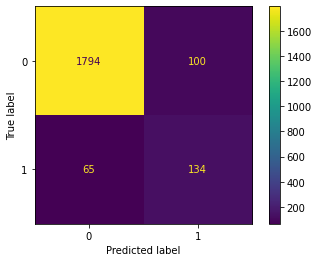

In [50]:
# Evaluates the model on the test set

preds, _ = trainer.evaluate("test", True)

In [ ]:
# Saves the final model to the given path
trainer.save_model("roberta-base-all-data", path="drive/MyDrive/nlp_cw/")

Model roberta-base-all-data saved to drive/MyDrive/nlp_cw//roberta-base-all-data.pth


# Evaluation on the Official Test Set

Performs inference on the official test dataset and saves the result

In [40]:
# Loads test samples
from dont_patronize_me import DontPatronizeMe
data_dir = "data/"
dataset = DontPatronizeMe(data_dir, data_dir + "task4_test.tsv")
dataset.load_test()

In [ ]:
preprocessor = Preprocessor()
official_test_dataset = dataset.test_set_df
preprocessor.preprocess(official_test_dataset)
official_test_text = official_test_dataset["text"].to_list()

tokenized_test_text = tokenizer(official_test_text, padding="max_length", max_length=128, truncation=True, return_tensors="pt")
test_text_tensor = torch.stack([tokenized_test_text["input_ids"], tokenized_test_text["attention_mask"]], dim=1)
official_test_dataset = TensorDataset(test_text_tensor)
loader_official_test = DataLoader(official_test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
trainer = Trainer(pcl_classifier, loader_train, loader_val, loader_test, loader_official_test, is_binary_classification=False)

In [ ]:
preds = trainer.predict_official_test()

100%|██████████| 120/120 [00:15<00:00,  7.75it/s]


In [ ]:
trainer.save_eval_result(preds, "drive/MyDrive/nlp_cw/result7.txt")

Dataframe saved to drive/MyDrive/nlp_cw/result7.txt


In [50]:
# Ensemble model inference

def read_label_from_file(path: str) -> np.ndarray:
  """
  Reads the given file containing the labels line by line,
  and returns an numpy array of all the labels.
  """
  labels = []
  with open(path, "r") as file:
    lines = file.readlines()
    for line in lines:
      labels.append(int(line))
  
  return np.array(labels)

def ensemble_predictions(label_files: List[Tuple[str, int]], path: str, 
              threshold: Optional[int] = None):
  """
  Aggregates predictions from several models and the
  final result will be obtained by performing majority voting
  on the aggregated predictions. Note that the second
  element in the tuple denotes the weight that is given to the model.
  For instance if a model has excellent performance, its votes will 
  be given more weights when the final predictions are calculated.

  Saves the final result as a txt file to the given path.
  
  If voting threshold is set, the final prediction will be
  positive even if a majority of the models vote negative as
  long as the threshold number is achieved.
  """
  neg_label = 0
  pos_label = 1
  model_count = len(label_files)
  if not threshold:
    threshold = model_count // 2 + 1
    
  # The number of models that are voting needs to be odd
  # assert(model_count & 1)
  aggregate_preds = []
  for file, weight in label_files:
    aggregate_preds.append(weight * read_label_from_file(file))
  aggregate_preds = np.stack(aggregate_preds, axis=1)
  preds = []
  for i in range(len(aggregate_preds)):
    # If the majority of the models predicts
    # that a sample is positive, the final label will be 1
    pos_votes = aggregate_preds[i].sum()
    if pos_votes >= threshold:
      preds.append(pos_label)
    else:
      preds.append(neg_label)
  print(np.unique(preds, return_counts=True))
  Trainer.save_eval_result(preds, path)

files = [
      # 1
      ("drive/MyDrive/nlp_cw/result.txt", 0.5), # 0.54
      # 2
      ("drive/MyDrive/nlp_cw/result1.txt", 2), # 0.57
      # 3
      ("drive/MyDrive/nlp_cw/result2.txt", 0.5), # 0.57
      # 4
      ("drive/MyDrive/nlp_cw/result3.txt", 0.5), # 0.54
      # 5
      ("drive/MyDrive/nlp_cw/result4.txt", 0.5), # 0.52
      # 11
      ("drive/MyDrive/nlp_cw/result5.txt", 0.5), # 0.54
      # 14
      ("drive/MyDrive/nlp_cw/result6.txt", 1), # 0.565
      # 16
      ("drive/MyDrive/nlp_cw/result7.txt", 0.5), # 0.535
      # From roy
      # 6
      ("drive/MyDrive/nlp_cw/pcl_model.txt", 0.5), # 0.515
      # 7
      ("drive/MyDrive/nlp_cw/pcl_model_ctr.txt", 2), # 0.57
      # 8
      ("drive/MyDrive/nlp_cw/pcl_model_ctr2.txt", 2), # 0.57
      # 9
      ("drive/MyDrive/nlp_cw/pcl_model_talkdown.txt", 0.5), # 0.53
      # 10
      ("drive/MyDrive/nlp_cw/pcl_model_bt_pos.txt", 1), # 0.56
      # 12
      ("drive/MyDrive/nlp_cw/pcl_model_bt_all.txt", 2), # 0.576
      # 13
      ("drive/MyDrive/nlp_cw/pcl_model_deberta.txt", 0.5), # 0.48
      # 15
      ("drive/MyDrive/nlp_cw/pcl_model_deberta_bt_all.txt", 2), # 0.59
      # 17
      ("drive/MyDrive/nlp_cw/pcl_model_categorical.txt", 2), # 0.57
      # 18
      ("drive/MyDrive/nlp_cw/pcl_model_cat32.txt", 0.5), # 0.54
      # 19
      ("drive/MyDrive/nlp_cw/pcl_model_sentiment.txt", 0.5),
      # 20
      ("drive/MyDrive/nlp_cw/pcl_model_deberta_cat.txt", 2) # 0.59
     ]

ensemble_predictions(files, "drive/MyDrive/nlp_cw/task1.txt", 8)

(array([0, 1]), array([3470,  362]))
Dataframe saved to drive/MyDrive/nlp_cw/task1.txt


## Ensemble model components
1. Roberta-large
  - Original dataset with no preprocessing (no augmentation)
  - 18 epochs
  - No contrastive learning
  - Without label smoothing
2. Roberta-large
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - No contrastive learning
  - With label smoothing (0.1)
3. Roberta-large (Same as model 2)
  - Original dataset preprocessed (no augmentation)
  - 15 epochs
  - No contrastive learning
  - With label smoothing (0.1)
4. Roberta-base
  - Original dataset preprocessed (no augmentation)
  - 15 epochs
  - No contrastive learning
  - With label smoothing (0.1)
5. Roberta-large
  - Original dataset with talkdown preprocessed
  - 18 epochs
  - No contrastive learning
  - With label smoothing (0.1)
6. Roberta-large 
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - No contrastive learning
  - Without label smoothing
7. Roberta-large
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - With contrastive learning
  - Without label smoothing
8. Roberta-large
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
9. Roberta-large
  - Original dataset with talkdown (without extensive preprocessing)
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
10. Roberta-large
  - Original dataset with back translation augmentation (only positive samples) preprocessed
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
11. Deberta-base-v3
  - Original dataset with talkdown preprocessed
  - 10 epochs
  - Without contrastive loss
  - With label smoothing (0.1)
12. Roberta-large
  - Original dataset with back translation augmentation (both negative and positive samples)
  - 20 epochs
  - With MSE constrastive loss
  - Without label smoothing
13. Deberta-base-v3
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
14. Deberta-v3-base
  - Original dataset preprocessed
  - 15 epochs
  - Without contrastive loss
  - With label smoothing (0.1)
15. Deberta-v3-large
  - Original dataset wtih back translation aumgentation preprocessed (both negative and positive samples)
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
16. Roberta-base
  - Trained on all available data (including dev set)
  - 10 epochs
  - Without contrastive loss
  - With label smoothing (0.1)
17. Robeta-large
  - Original dataset with categorical data appended to the start of the text
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
18. Roberta-large
  - Original dataset wtih duplicated categorical data appended to the start and end of the text samples
  - 20 epochs
  - With MSE contrastive loss
  - Without label smoothing
19. Sentiment-roberta-large-english
  - Original dataset preprocessed (no augmentation)
  - 20 epochs
  - With MSE loss
  - Without label smoothing
20. Deberta-v3-large
  - Original dataset with categorical data appended to the start of the text
  - 20 epochs
  - With MSE loss
  - Without label smoothing